## YOLO + microsam prediction

Import Yolo and setup paths

In [60]:
import numpy as np
import napari
print("Napari version:", napari.__version__)
from pathlib import Path
from segment_everything.weights_helper import get_weights_path
from segment_everything.object_detectors.yolo_detector import YoloDetector

Napari version: 0.6.6


### Use Pixi to get a reproducible kernel for this notebook

This repo contains a Pixi environment manifest at `pixi/pixi.toml` that describes the Python environment used for `segment_everything` (packages, Python version, and a `register-kernel` task).

Quick commands

- Create environment with Pixi (follow your Pixi workflow):

```bash
# create/restore the environment (example pixi command)
pixi install
```

- Register the environment as a Jupyter kernel (runs the `register-kernel` task in `pixi/pixi.toml`):

```bash
# run the register-kernel task 
pixi task run register-kernel
```


### Load test image

In [61]:
tnia_images_path = Path(r"D:\images")
tnia_images_path = Path(r"/home/bnorthan/images")
parent_path=Path(tnia_images_path / r'tnia-python-images/imagesc/2025_05_10_SOTA_Test_Set')

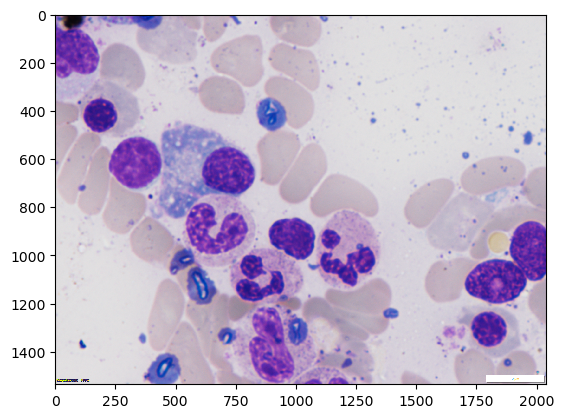

In [62]:
from skimage.io import imread
import matplotlib.pyplot as plt

img = imread(parent_path / r"TestHidden_005.bmp")

# create grayscale only for napari display (temporary napari bug with RGB + 3D labels)
img_grayscale = img.mean(axis=2).astype(np.uint8)

# show original image with matplotlib
plt.imshow(img)

### Detect Bounding Boxes with YOLO

Set up a bounding box detector.  Here I use a Yolo detector vendored from mobilesam, but any bounding box detector would work for this step. 

In [63]:
weights_path = str(get_weights_path("ObjectAwareModel"))
weights_path = str(get_weights_path("ObjectAwareModelHuggingFace"))
yolo_detector_object_aware = YoloDetector(weights_path, "ObjectAwareModelFromMobileSamV2", device='cuda')

Generate bounding boxes with YOLO

In [64]:
results = yolo_detector_object_aware.get_results(img, conf=0.2, imgsz=2048)


0: 1568x2048 106 objects, 213.9ms
Speed: 12.8ms preprocess, 213.9ms inference, 1.1ms postprocess per image at shape (1, 3, 2048, 2048)
0: 1568x2048 106 objects, 213.9ms
Speed: 12.8ms preprocess, 213.9ms inference, 1.1ms postprocess per image at shape (1, 3, 2048, 2048)


Get the classes and the bounding boxes from the Yolo result.  Convert bbox to Napari and Microsam format. 


In [65]:
# Use YoloDetector helpers to get boxes in the desired formats

bboxes_microsam = yolo_detector_object_aware.get_microsam_bboxes(img, conf=0.2, imgsz=2048)
boxes_napari = yolo_detector_object_aware.get_napari_bboxes(img, conf=0.2, imgsz=2048)

Predicting bounding boxes for image data


0: 1568x2048 106 objects, 214.7ms
Speed: 10.7ms preprocess, 214.7ms inference, 1.1ms postprocess per image at shape (1, 3, 2048, 2048)
Speed: 10.7ms preprocess, 214.7ms inference, 1.1ms postprocess per image at shape (1, 3, 2048, 2048)




Predicting bounding boxes for image data


0: 1568x2048 106 objects, 213.5ms
Speed: 10.8ms preprocess, 213.5ms inference, 1.1ms postprocess per image at shape (1, 3, 2048, 2048)
Speed: 10.8ms preprocess, 213.5ms inference, 1.1ms postprocess per image at shape (1, 3, 2048, 2048)


### Use microsam for mask generation

In [66]:
from segment_everything.stacked_labels import StackedLabels
from segment_everything.mask_detectors.microsam import microsam_detector

detector = microsam_detector(model_type="vit_b_lm", device='cpu')
detector.set_image(img)
mask_list = detector.segment_boxes(bboxes_microsam)


Compute Image Embeddings 2D: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]



### Use StackedLabels to make label images

In [67]:
stacked_labels = StackedLabels(mask_list)
labels = stacked_labels.make_3d_labels()


In [68]:
viewer = napari.Viewer()
viewer.add_image(img_grayscale, name='image')
viewer.add_labels(labels, name='labels', scale=(3,1,1))

<Labels layer 'labels' at 0x769e7ae37150>

### Send bounding boxes to Napari

In [69]:
shapes_layer = viewer.add_shapes(name='bboxes', face_color= 'transparent', edge_color='green', edge_width=3)

for bbox_microsam in boxes_napari:
    shapes_layer.add_rectangles([bbox_microsam])

### Use StackedLabels to make 2D label image

... and visualize with skimage

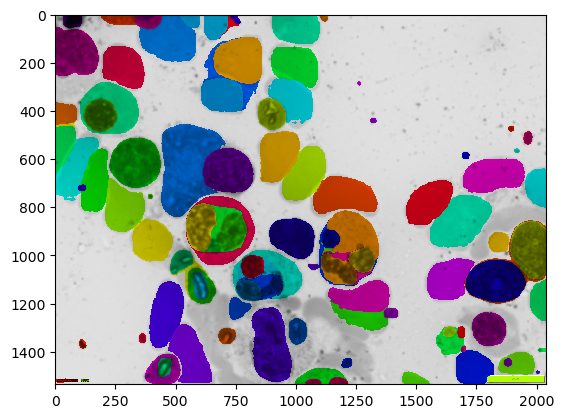

In [70]:
from tnia.plotting.plt_helper import mask_overlay


test = stacked_labels.make_2d_labels(type="max")

plt.imshow(mask_overlay(img, test))

### Add slice to 3D labels

This is useful to add a new label instance to the 3D labels

In [59]:
# append empty zero slice to labels 

temp = np.zeros((1, viewer.layers['labels'].data.shape[1], viewer.layers['labels'].data.shape[2]))
temp = temp.astype(viewer.layers['labels'].data.dtype)

viewer.layers['labels'].data = np.concatenate([viewer.layers['labels'].data, temp], axis=0)
